Perplexity 에이전트 시스템

In [1]:
# !pip install langchain_chroma pytube youtube-search youtbue-transcript-api next_asyncio wolframalpha arxiv

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

WolframAlpha API 활용을 위한 비동기 설정
- async 호출만 가능하므로 nest_asyncio이용

In [3]:
import asyncio
asyncio.set_event_loop_policy(asyncio.DefaultEventLoopPolicy())

import nest_asyncio
nest_asyncio.apply()

In [4]:
from langchain_community.utilities.wolfram_alpha import WolframAlphaAPIWrapper
wolfram = WolframAlphaAPIWrapper()

In [5]:
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    focus: Literal["web", "academic", "video", "math"]

웹 검색, 눈문 검색, 수학 계산 도구 정의

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools import YouTubeSearchTool
from langchain_community.utilities.wolfram_alpha import WolframAlphaAPIWrapper
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
import re

web_tool = TavilySearchResults(max_results=3)

@tool
def academic_tool(query:str):
    """
    academic paper search tool
    """
    arxiv = ArxivAPIWrapper()
    docs = arxiv.run(query)
    return docs

@tool
def math_tool(query:str):
    """
    math tool
    """
    wolfram = WolframAlphaAPIWrapper()
    result = wolfram.run(query)
    return result

In [7]:
# Test
academic_tool.run("DeepSeek Principle")

"Published: 2024-12-13\nTitle: DeepSeek-VL2: Mixture-of-Experts Vision-Language Models for Advanced Multimodal Understanding\nAuthors: Zhiyu Wu, Xiaokang Chen, Zizheng Pan, Xingchao Liu, Wen Liu, Damai Dai, Huazuo Gao, Yiyang Ma, Chengyue Wu, Bingxuan Wang, Zhenda Xie, Yu Wu, Kai Hu, Jiawei Wang, Yaofeng Sun, Yukun Li, Yishi Piao, Kang Guan, Aixin Liu, Xin Xie, Yuxiang You, Kai Dong, Xingkai Yu, Haowei Zhang, Liang Zhao, Yisong Wang, Chong Ruan\nSummary: We present DeepSeek-VL2, an advanced series of large Mixture-of-Experts (MoE)\nVision-Language Models that significantly improves upon its predecessor,\nDeepSeek-VL, through two key major upgrades. For the vision component, we\nincorporate a dynamic tiling vision encoding strategy designed for processing\nhigh-resolution images with different aspect ratios. For the language\ncomponent, we leverage DeepSeekMoE models with the Multi-head Latent Attention\nmechanism, which compresses Key-Value cache into latent vectors, to enable\nefficie

In [8]:
# Test
math_tool.run("123*123^2")

'Assumption: 123×123^2 \nAnswer: 1860867'

In [9]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.tools import YouTubeSearchTool
from langchain_community.document_loaders import YoutubeLoader
from langchain_core.documents import Document
import ast

youtube_search_tool = YouTubeSearchTool()

@tool
def video_tool(query: str) -> str:
    """
    Retriever tool for the transcript for a YouTube video.
    If user want to find some information, this tool is good to gather youtube video information.
    query should be given in string format.
    """
    urls = youtube_search_tool.run(query)
    urls = ast.literal_eval(urls)
    docs = []
    for url in urls:
        loader = YoutubeLoader.from_youtube_url(
            url, add_video_info=True, language=["en", "ko"]
        )
        scripts = loader.load()
        script_content = scripts[0].page_content
        # title = scripts[0].metadata['title']
        # author = scripts[0].metadata['author']
        author = "Unknown"
        title = "Unknown"
        doc = Document(page_content=script_content, metadata={"source": url, "title": title, "author":author})
        docs.append(doc)

    text_splitter = RecursiveCharacterTextSplitter(
        separators = ["\n\n", "\n", ".", ",", " ", ""],
        chunk_size = 1000, chunk_overlap=0
    )
    texts = text_splitter.split_documents(docs)
    embeddings = OpenAIEmbeddings()
    db = Chroma.from_documents(texts, embeddings)
    retriever = db.as_retriever()
    retrieved_docs = retriever.invoke(query)

    video_results = []
    for doc in retrieved_docs:
        title = doc.metadata.get('title', 'No title available')
        author = doc.metadata.get('author', 'No author available')
        script_content = doc.page_content

        video_info = f"""
        Video Information:
        ------------------
        Title: {title}
        Author: {author}
        Transcript: {script_content}
        ------------------
        """
        video_results.append(video_info)
    
    return "\n\n".join(video_results)

In [10]:
video_tool.run("IU가 누구야?")

'\n        Video Information:\n        ------------------\n        Title: Unknown\n        Author: Unknown\n        Transcript: [음악] 구독과 좋아요 그리고 알림 설정은 제작자에게 매우 큰 힘이 됩니다 가수 아이유의 브랜드 평판 지수가 한 달 사이 19위에서 75위로 급락한 것은 단순한 숫자 변화 이상의 의미를 지닌다 아이유는 한때 국민여동생이라는 칭호로 사랑받았지만 이제는 인민 여동생이라는 비아냥 섞인 별칭을 듣는 지경에 이르렀다 그야말로 아에서 유로 전락한 것이다 이번 브랜드 평판지수의 급락은 그녀가 윤성열 대통령 탄핵 찬성 집회와 관련된 행동을 통해 보수 국민들의 정서를 정면으로 건드린 데서 비롯된 것이 아니겠냐는 분석이 나온다 아이유가 탄핵찬성 집회 주변 가게에 성결을 하며 간접적으로 탄핵 찬성을 지지하고 나아가 내란을 선동하는듯한 모습을 보였다는 것은 많은 국민들에게 실망을 안겨줬다가 아가 14일 윤대 탄핵을 촉구하는는 빵과 국밥 등을 준비했습니다 아의 소속사 이담 엔터테인먼트는 13일 날시에 아이크를 들고 집회 참석해 주변을 환히 밝히는 유아의 손이 조금이라도 따뜻해지길 바라며 먹거리와 핫팩을 준비했다고 공식 팬카페에 공지했습니다 바이유 측이 준비한 먹이는 빵 100개 음료 백잔 국밥과 곰탕 100그릇 따로국밥 100그릇 떡 100개 등입니다 이런 행위가 대한민국의 자유민주주의를 위협하는 세력을 지원하는 것으로 해될 수 있 에서 비판은 당연한 비결이다 그녀의 이런 모습은 대한민국 국민들이 기대했던 건강한 대중문화 아이콘의 모습과 완전히 대치된다 국민 모두에게 사랑받던 이미지가 특정 정치 세력의 편해서 논란을 키우는 행동으로 크게 훼손된 것이다 아유의 행동은 단순히 연예인의 정치적 의견 표출로 볼 문제가 아니다 탄핵 찬성을 지지하는 태도를 보이는 것은 사실상 국민을 분열시키고 대한민국 헌법과 자유민주주의의 기본 가치를 흔드는 행위로 비춰질 수 있다 결

In [12]:
# from pytube import YouTube
# yt = YouTube(f"https://www.youtube.com/watch?v=rqAE9OiK4CY")
# yt = YouTube(f"https://www.youtube.com/watch?v=pDvBiB1waBk")
# print(yt.vid_info)
# video_info = {
#     "title": yt.title or "Unknown",
#     "description": yt.description or "Unknown",
#     "view_count": yt.views or 0,
#     "thumbnail_url": yt.thumbnail_url or "Unknown",
#     "publish_date": yt.publish_date.strftime("%Y-%m-%d %H:%M:%S")
#     if yt.publish_date
#     else "Unknown",
#     "length": yt.length or 0,
#     "author": yt.author or "Unknown",
# }
# print(video_info)

In [13]:
tools = {
    "web": [web_tool],
    "academic": [academic_tool],
    "video": [video_tool],
    "math": [math_tool],
}

tool_nodes = {focus: ToolNode(tools[focus]) for focus in tools}

In [14]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot(state: State):
    llm_with_tools = llm.bind_tools(tools[state["focus"]])
    result = llm_with_tools.invoke(state["messages"])
    return {"messages": [result]}

In [15]:
from langgraph.graph import StateGraph, END

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
for focus, tool_node in tool_nodes.items():
    graph_builder.add_node(f"{focus}_tools", tool_node)

def focus_condition(state):
    if state["messages"][-1].tool_calls:
        return f"{state['focus']}_tools"
    return END

graph_builder.add_conditional_edges(
    "chatbot",
    focus_condition,
    {
        "web_tools": "web_tools",
        "academic_tools": "academic_tools",
        "video_tools": "video_tools",
        "math_tools": "math_tools",
        END: END,
    }
)

for focus in tools:
    graph_builder.add_edge(f"{focus}_tools", "chatbot")

graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()


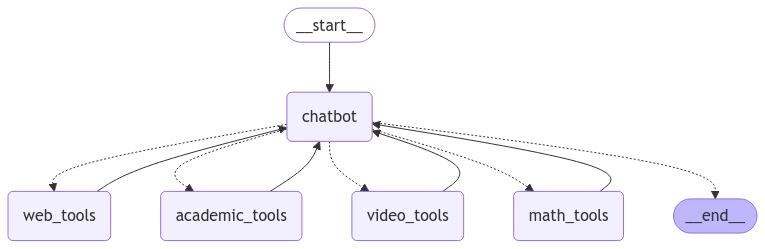

In [16]:
from util import display_graph

display_graph(graph)

In [17]:
from langchain_core.messages import HumanMessage

init_state = {
    "messages": [HumanMessage(content="IU의 최신곡은 뭐야?")],
    "focus": "video"
}

for chunk in graph.stream(init_state, stream_mode="values",):
    print(chunk['messages'][-1].content)

IU의 최신곡은 뭐야?


        Video Information:
        ------------------
        Title: Unknown
        Author: Unknown
        Transcript: [음악] 구독과 좋아요 그리고 알림 설정은 제작자에게 매우 큰 힘이 됩니다 가수 아이유의 브랜드 평판 지수가 한 달 사이 19위에서 75위로 급락한 것은 단순한 숫자 변화 이상의 의미를 지닌다 아이유는 한때 국민여동생이라는 칭호로 사랑받았지만 이제는 인민 여동생이라는 비아냥 섞인 별칭을 듣는 지경에 이르렀다 그야말로 아에서 유로 전락한 것이다 이번 브랜드 평판지수의 급락은 그녀가 윤성열 대통령 탄핵 찬성 집회와 관련된 행동을 통해 보수 국민들의 정서를 정면으로 건드린 데서 비롯된 것이 아니겠냐는 분석이 나온다 아이유가 탄핵찬성 집회 주변 가게에 성결을 하며 간접적으로 탄핵 찬성을 지지하고 나아가 내란을 선동하는듯한 모습을 보였다는 것은 많은 국민들에게 실망을 안겨줬다가 아가 14일 윤대 탄핵을 촉구하는는 빵과 국밥 등을 준비했습니다 아의 소속사 이담 엔터테인먼트는 13일 날시에 아이크를 들고 집회 참석해 주변을 환히 밝히는 유아의 손이 조금이라도 따뜻해지길 바라며 먹거리와 핫팩을 준비했다고 공식 팬카페에 공지했습니다 바이유 측이 준비한 먹이는 빵 100개 음료 백잔 국밥과 곰탕 100그릇 따로국밥 100그릇 떡 100개 등입니다 이런 행위가 대한민국의 자유민주주의를 위협하는 세력을 지원하는 것으로 해될 수 있 에서 비판은 당연한 비결이다 그녀의 이런 모습은 대한민국 국민들이 기대했던 건강한 대중문화 아이콘의 모습과 완전히 대치된다 국민 모두에게 사랑받던 이미지가 특정 정치 세력의 편해서 논란을 키우는 행동으로 크게 훼손된 것이다 아유의 행동은 단순히 연예인의 정치적 의견 표출로 볼 문제가 아니다 탄핵 찬성을 지지하는 태도를 보이는 것은 사실상 국민을 분열시키고 대한민국 헌법과 자유민주주의의 기본 가치를 흔드는 행위로 비춰